**Downloading the data**



In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  48.4M      0  0:00:01  0:00:01 --:--:-- 48.4M


Preparing the data

In [ ]:
import os, pathlib, shutil, random
from tensorflow import keras
batchSize = 32
base_dir= pathlib.Path("/content/aclImdb")
val_dir = base_dir/ "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category, exist_ok=True )

    files = os.listdir(train_dir / category)
    random.Random(1496).shuffle(files)
    num_val_samples = 10000
    validation_files = files[-num_val_samples:]
    for fname in validation_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

raw_train_dataset = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batchSize
).take(100)  # Restrict training samples to 100

raw_validation_dataset = keras.utils.text_dataset_from_directory(
    "/content/aclImdb/val", batch_size=batchSize
)
raw_test_dataset = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batchSize
)
te_only_raw_train_dataset = raw_train_dataset.map(lambda x, y: x)


Found 5000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


Setting up datasets for numeric sequences

**A sequence sentiment_classifier built on one-hot encoded vector sequences**

In [ ]:
from tensorflow.keras import layers

MAX_SEQUENCE_LENGTH = 150   # Cutoff reviews after 150 words
MAX_VOCAB_SIZE = 10000      # Consider only the top 10,000 words

# Define TextVectorization layer
text_vectorizer_layer = layers.TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_SEQUENCE_LENGTH,
)

# Extract texts only from raw_train_dataset for vectorization adaptation
train_texts_only = raw_train_dataset.map(lambda x, y: x)
text_vectorizer_layer.adapt(train_texts_only)

# Vectorize the train, validation, and test datasets
raw_train_dataset_vectorized = raw_train_dataset.map(
    lambda x, y: (text_vectorizer_layer(x), y),
    num_parallel_calls=4
)
val_dataset_vectorized = raw_validation_dataset.map(
    lambda x, y: (text_vectorizer_layer(x), y),
    num_parallel_calls=4
)
raw_test_dataset_vectorized = raw_test_dataset.map(
    lambda x, y: (text_vectorizer_layer(x), y),
    num_parallel_calls=4
)


In [ ]:
import tensorflow as tf  # sentiment_classifier with embedding layer

input_tokens = keras.Input(shape=(None,), dtype="int64")
trainable_embedding_layer_output = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256, mask_zero=True)(input_tokens)
x = layers.Bidirectional(layers.LSTM(32))(trainable_embedding_layer_output)
x = layers.Dropout(0.5)(x)
prediction_layer = layers.Dense(1, activation="sigmoid")(x)

sentiment_classifier = keras.Model(input_tokens, prediction_layer)
sentiment_classifier.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

sentiment_classifier.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 256) │  2,560,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 64)        │     73,984 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

Developing a fundamental sequencing concept initially

In [ ]:
model_checkpoint_callback = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras", save_best_only=True)
]

history = sentiment_classifier.fit(
    raw_train_dataset_vectorized,
    validation_data=val_dataset_vectorized,
    epochs=15,
    callbacks=model_checkpoint_callback
)



Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.5234 - loss: 0.6907 - val_accuracy: 0.6611 - val_loss: 0.6360
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.6969 - loss: 0.5928 - val_accuracy: 0.7649 - val_loss: 0.5040
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.7965 - loss: 0.4388 - val_accuracy: 0.7950 - val_loss: 0.4493
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.8663 - loss: 0.3259 - val_accuracy: 0.7834 - val_loss: 0.4592
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9035 - loss: 0.2396 - val_accuracy: 0.7685 - val_loss: 0.5659
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9414 - loss: 0.1497 - val_accuracy: 0.7665 - val_loss: 0.5198
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 0.9620 - loss: 0.1183 - val_accuracy: 0.7254 - val_loss: 0.8969
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.9750 - loss: 0.071

In [ ]:
sentiment_classifier = keras.models.load_model('one_hot_bidir_lstm.keras')
print(f"Test acc: {sentiment_classifier.evaluate(raw_test_dataset_vectorized)[1]:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7966 - loss: 0.4466
Test acc: 0.790


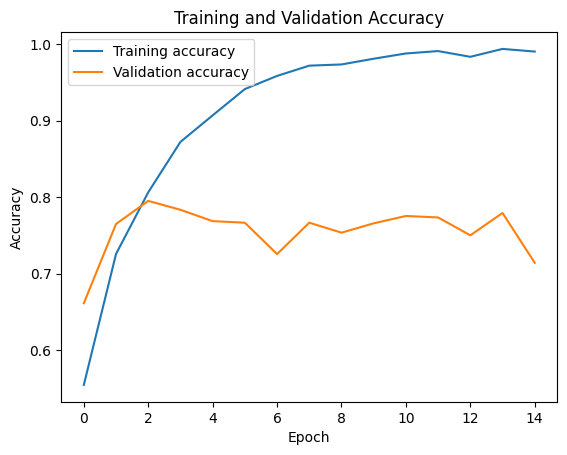

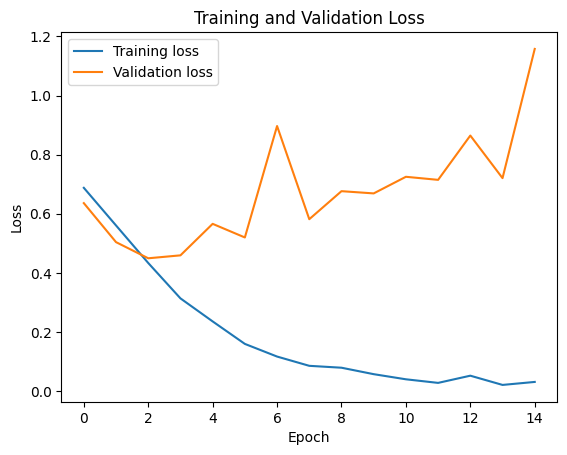

In [ ]:

import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



# Using the Embedded level to acquire embedded words

Putting an Anchoring level into Action


In [ ]:
em_layer = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256)

Anchor layer system which was developed form start

In [ ]:
# Define the model
in1 = keras.Input(shape=(None,), dtype="int64")
em1 = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256)(in1)
x = layers.Bidirectional(layers.LSTM(32))(em1)
x = layers.Dropout(0.5)(x)
prediction_layer1 = layers.Dense(1, activation="sigmoid")(x)

# Build the model correctly
sentiment_classifier = keras.Model(in1, prediction_layer1)

# Compile correctly
sentiment_classifier.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Model summary
sentiment_classifier.summary()




Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, None, 256)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Correct ModelCheckpoint
model_checkpoint_callback1 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras", save_best_only=True)
]

# Correct model fitting
history1 = sentiment_classifier.fit(
    raw_train_dataset_vectorized,
    validation_data=val_dataset_vectorized,
    epochs=15,
    callbacks=model_checkpoint_callback1
)

# Correct way to load the best saved model
sentiment_classifier = keras.models.load_model("embeddings_bidir_gru.keras")

# Evaluate the loaded model
print(f"Test acc: {sentiment_classifier.evaluate(raw_test_dataset_vectorized)[1]:.3f}")


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.5015 - loss: 0.6938 - val_accuracy: 0.5414 - val_loss: 0.6872
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.6283 - loss: 0.6607 - val_accuracy: 0.6469 - val_loss: 0.6808
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.7256 - loss: 0.5694 - val_accuracy: 0.7538 - val_loss: 0.5178
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.8136 - loss: 0.4495 - val_accuracy: 0.7774 - val_loss: 0.4803
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.8556 - loss: 0.3628 - val_accuracy: 0.7897 - val_loss: 0.4658
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.8898 - loss: 0.2873 - val_accuracy: 0.7778 - val_loss: 0.5337
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9186 - loss: 0.2208 - val_accuracy: 0.7764 - val_loss: 0.5127
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9455 - loss: 0.1564 - val_

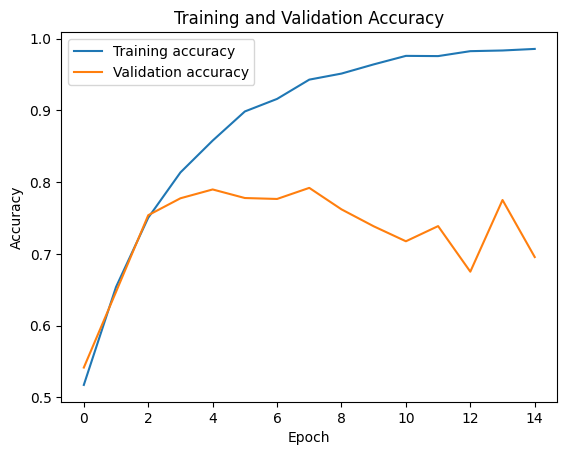

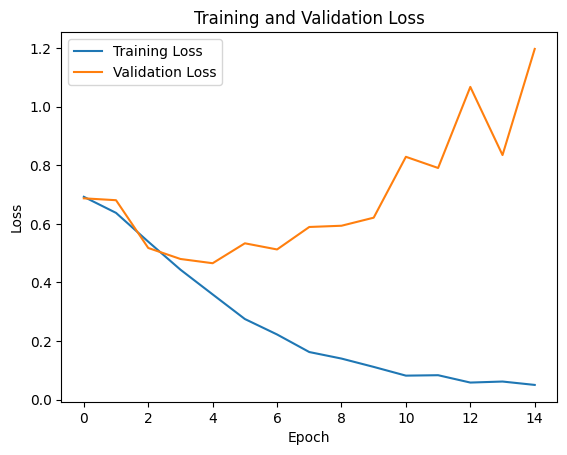

In [ ]:
# Plot training and validation accuracy
plt.plot(history1.history['accuracy'], label='Training accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Recognizing blurring and filling

Applying filtering to an Anchoring level


In [ ]:
in2 = keras.Input(shape=(None,), dtype="int64")
em2 = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256, mask_zero=True)(in2)
x = layers.Bidirectional(layers.LSTM(32))(em2)
x = layers.Dropout(0.5)(x)
prediction_layer2 = layers.Dense(1, activation="sigmoid")(x)

# ❗ Correct way to create the model
sentiment_classifier = keras.Model(in2, prediction_layer2)

# ❗ Correct way to compile the model
sentiment_classifier.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# ❗ Correct way to print model summary
sentiment_classifier.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, None, 256) │  2,560,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, None)      │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 64)        │     73,984 │ embedding_4[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_checkpoint_callback2 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras", save_best_only=True)
]

history2 = sentiment_classifier.fit(
    raw_train_dataset_vectorized,
    validation_data=val_dataset_vectorized,
    epochs=15,
    callbacks=model_checkpoint_callback2
)


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.5439 - loss: 0.6893 - val_accuracy: 0.6628 - val_loss: 0.6195
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.7106 - loss: 0.5763 - val_accuracy: 0.7469 - val_loss: 0.5087
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.8084 - loss: 0.4293 - val_accuracy: 0.7963 - val_loss: 0.4636
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.8675 - loss: 0.3163 - val_accuracy: 0.7916 - val_loss: 0.4876
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 0.9181 - loss: 0.2216 - val_accuracy: 0.7835 - val_loss: 0.5010
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.9415 - loss: 0.1533 - val_accuracy: 0.7849 - val_loss: 0.4814
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.9516 - loss: 0.1314 - val_accuracy: 0.7931 - val_loss: 0.5206
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.9730 - loss: 0.0

In [ ]:

sentiment_classifier = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {sentiment_classifier.evaluate(raw_test_dataset_vectorized)[1]:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8000 - loss: 0.4544
Test acc: 0.794


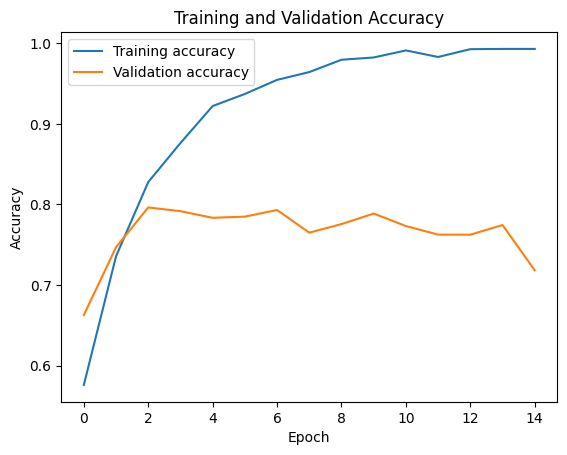

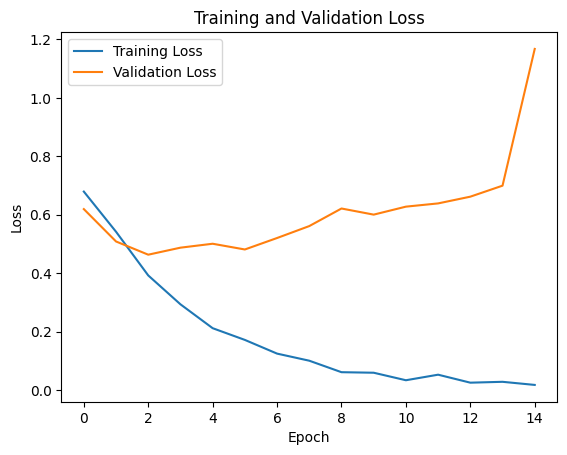

In [ ]:
# Plot training and validation accuracy
plt.plot(history2.history['accuracy'], label='Training accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Preconditioned word embeds are used

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-04-18 18:09:31--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-18 18:09:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-18 18:09:31--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Interpreting the word-embeddings package for One

In [ ]:
import numpy as np
GLOVE_FILE_PATH = "glove.6B.100d.txt"

glove_embeddings = {}
with open(GLOVE_FILE_PATH) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_embeddings[word] = coefs

print(f"Found {len(glove_embeddings)} word vectors.")

Found 400000 word vectors.


Setting up the matrix for the GloVe website embedded words

In [ ]:
embedding_dimension = 100

vocab = text_vectorizer_layer.get_vocabulary()
vocab_to_index = dict(zip(vocab, range(len(vocab))))

glove_embedding_matrix = np.zeros((MAX_VOCAB_SIZE, embedding_dimension))
for word, i in vocab_to_index.items():
    if i < MAX_VOCAB_SIZE:
        em_vector = glove_embeddings.get(word)
    if em_vector is not None:
        glove_embedding_matrix[i] = em_vector

In [ ]:
em_layer = layers.Embedding(
    MAX_VOCAB_SIZE,
    embedding_dimension,
    embeddings_initializer=keras.initializers.Constant(glove_embedding_matrix),
    trainable=False,
    mask_zero=True,
)

# Architecture with an embedded level which has been trained

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the model input
in4 = keras.Input(shape=(None,), dtype="int64")

# Apply the embedding layer
em4 = em_layer(in4)

# Define the LSTM layer with bidirectional wrapper
x = layers.Bidirectional(layers.LSTM(32))(em4)

# Apply dropout for regularization
x = layers.Dropout(0.5)(x)

# Define the output layer with sigmoid activation
prediction_layer4 = layers.Dense(1, activation="sigmoid")(x)

# Create the model
sentiment_classifier = keras.Model(inputs=in4, outputs=prediction_layer4)

# Compile the model
sentiment_classifier.compile(optimizer="rmsprop",
                        loss="binary_crossentropy",
                        metrics=["accuracy"])

# Display the model summary
sentiment_classifier.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, None, 100) │  1,000,000 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_6         │ (None, None)      │          0 │ input_layer_5[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 64)        │     34,048 │ embedding_6[2][0… │
│ (Bidirectional)     │                   │            │ not_equal_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,034,113 (3.94 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras

# Define the ModelCheckpoint callback correctly
model_checkpoint_callback4 = [
    ModelCheckpoint("glove_embeddings_sequence_sentiment_classifier.keras",
                    save_best_only=True)
]

# Train the model
history4 = sentiment_classifier.fit(raw_train_dataset_vectorized,
                               validation_data=val_dataset_vectorized,
                               epochs=15,
                               callbacks=model_checkpoint_callback4)

# Load the best model saved during training
sentiment_classifier = keras.models.load_model("glove_embeddings_sequence_sentiment_classifier.keras")

# Evaluate the model on the test dataset
test_accuracy = sentiment_classifier.evaluate(raw_test_dataset_vectorized)[1]
print(f"Test sentiment_classifier_accuracy: {test_accuracy:.3f}")


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.5017 - loss: 0.7095 - val_accuracy: 0.6062 - val_loss: 0.6623
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.6079 - loss: 0.6574 - val_accuracy: 0.6891 - val_loss: 0.5921
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.6857 - loss: 0.5952 - val_accuracy: 0.7321 - val_loss: 0.5478
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.7155 - loss: 0.5604 - val_accuracy: 0.6578 - val_loss: 0.6126
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.7431 - loss: 0.5194 - val_accuracy: 0.7305 - val_loss: 0.5359
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - accuracy: 0.7752 - loss: 0.4868 - val_accuracy: 0.6312 - val_loss: 0.6620
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 94ms/step - accuracy: 0.7836 - loss: 0.4712 - val_accuracy: 0.7765 - val_loss: 0.4751
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.7896 - loss: 0.4535 -

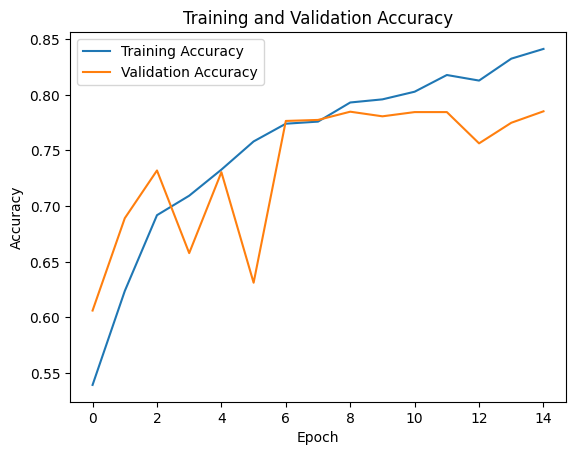

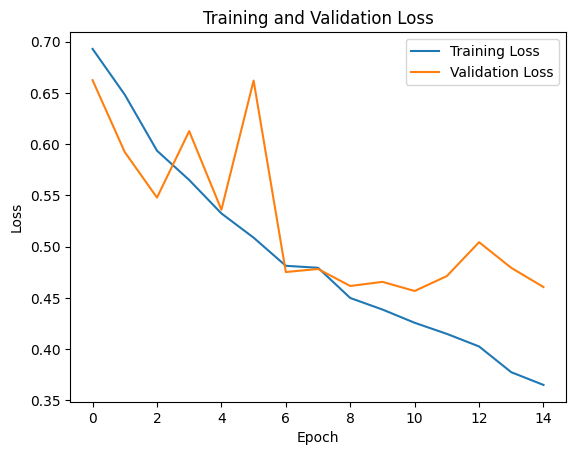

In [ ]:
# Plot training and validation accuracy
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Found 5000 files belonging to 2 classes.
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.5225 - loss: 0.6920 - val_accuracy: 0.5641 - val_loss: 0.6891
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.6133 - loss: 0.6708 - val_accuracy: 0.6992 - val_loss: 0.5942
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - accuracy: 0.7579 - loss: 0.5327 - val_accuracy: 0.7728 - val_loss: 0.4958
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.8219 - loss: 0.4189 - val_accuracy: 0.7886 - val_loss: 0.4633
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.8701 - loss: 0.3415 - val_accuracy: 0.7893 - val_loss: 0.4649
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.8998 - loss: 0.2705 - val_accuracy: 0.7760 - val_loss: 0.4831
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.9313 - loss: 0.1941 - val_accuracy: 0.7919 - val_loss: 0.5052
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step

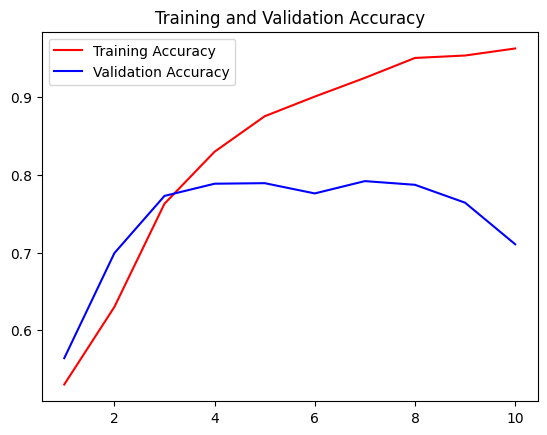

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.5372 - loss: 0.7041 - val_accuracy: 0.6097 - val_loss: 0.6611
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.6378 - loss: 0.6414 - val_accuracy: 0.7097 - val_loss: 0.5751
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.7088 - loss: 0.5763 - val_accuracy: 0.7347 - val_loss: 0.5409
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.7369 - loss: 0.5285 - val_accuracy: 0.7412 - val_loss: 0.5272
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.7665 - loss: 0.4938 - val_accuracy: 0.7582 - val_loss: 0.5037
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.7686 - loss: 0.4851 - val_accuracy: 0.7594 - val_loss: 0.5004
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.7944 - loss: 0.4515 - val_accuracy: 0.7738 - val_loss: 0.4755
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.8003 - loss: 0.4357 - val_ac

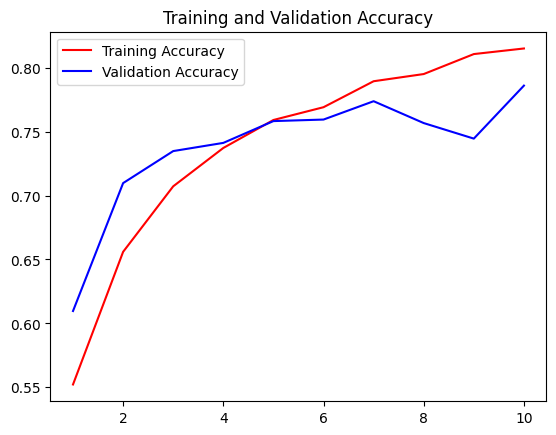

Training samples: 100
Embedding layer test accuracy: 0.785
Pretrained embeddings test accuracy: 0.769
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.5151 - loss: 0.6922 - val_accuracy: 0.5944 - val_loss: 0.6692
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.6881 - loss: 0.6038 - val_accuracy: 0.6560 - val_loss: 0.6304
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.8049 - loss: 0.4501 - val_accuracy: 0.7256 - val_loss: 0.5939
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8556 - loss: 0.3567 - val_accuracy: 0.7699 - val_loss: 0.5215
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.9057 - loss: 0.2677 - val_accuracy: 0.8127 - val_loss: 0.4568
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9152 - loss: 0.2400 - val_accuracy: 0.8137 - val_loss: 0.5342
Epoch 7/10
157/157 ━━━━━━━━━━━━

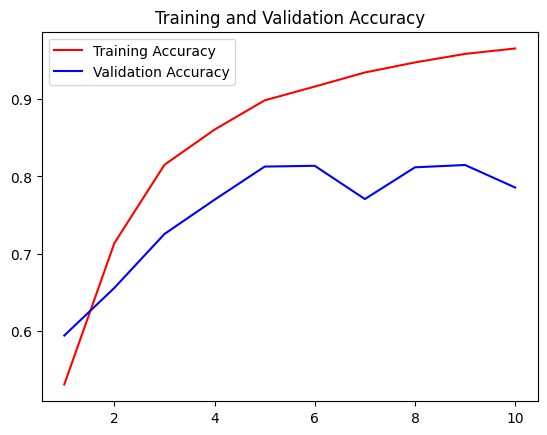

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.5530 - loss: 0.6921 - val_accuracy: 0.6234 - val_loss: 0.6366
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.6641 - loss: 0.6120 - val_accuracy: 0.7183 - val_loss: 0.5600
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.7303 - loss: 0.5543 - val_accuracy: 0.7401 - val_loss: 0.5359
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.7427 - loss: 0.5265 - val_accuracy: 0.7570 - val_loss: 0.5062
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.7670 - loss: 0.4880 - val_accuracy: 0.7542 - val_loss: 0.5145
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.7793 - loss: 0.4764 - val_accuracy: 0.7521 - val_loss: 0.5025
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.7864 - loss: 0.4570 - val_accuracy: 0.7438 - val_loss: 0.5120
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 0.7953 - loss: 0.4370 - va

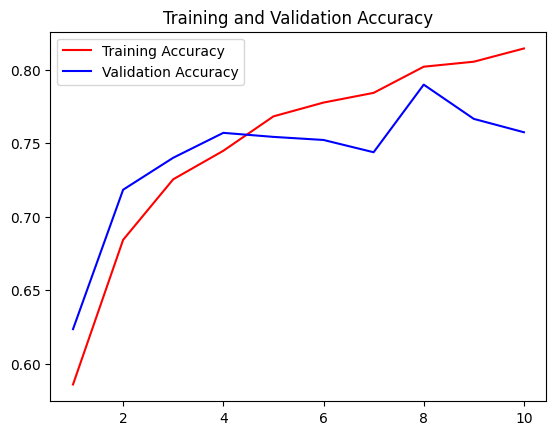

Training samples: 500
Embedding layer test accuracy: 0.806
Pretrained embeddings test accuracy: 0.788
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.5049 - loss: 0.6919 - val_accuracy: 0.6445 - val_loss: 0.6276
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.7129 - loss: 0.5774 - val_accuracy: 0.7120 - val_loss: 0.5734
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.8091 - loss: 0.4544 - val_accuracy: 0.7171 - val_loss: 0.5848
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8544 - loss: 0.3620 - val_accuracy: 0.7909 - val_loss: 0.4943
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.8804 - loss: 0.3071 - val_accuracy: 0.7742 - val_loss: 0.5202
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9094 - loss: 0.2621 - val_accuracy: 0.8042 - val_loss: 0.4561
Epoch 7/10
157/157 ━━━━━━━━━━━

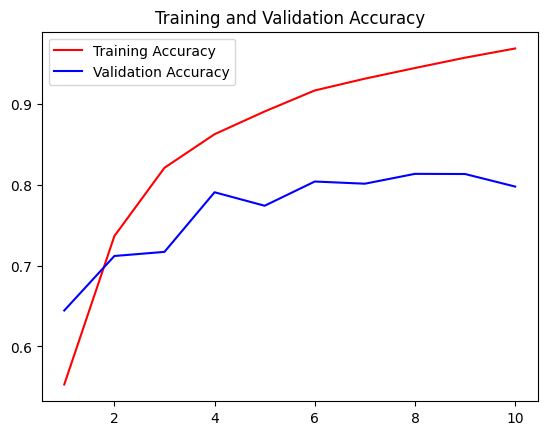

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.5366 - loss: 0.6952 - val_accuracy: 0.6064 - val_loss: 0.6541
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.6583 - loss: 0.6219 - val_accuracy: 0.7326 - val_loss: 0.5526
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - accuracy: 0.7212 - loss: 0.5556 - val_accuracy: 0.5572 - val_loss: 0.8540
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.7488 - loss: 0.5205 - val_accuracy: 0.7442 - val_loss: 0.5175
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.7746 - loss: 0.4879 - val_accuracy: 0.6990 - val_loss: 0.6016
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.7815 - loss: 0.4779 - val_accuracy: 0.7632 - val_loss: 0.4847
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.8008 - loss: 0.4417 - val_accuracy: 0.7614 - val_loss: 0.5128
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.7960 - loss: 0.4392 - val

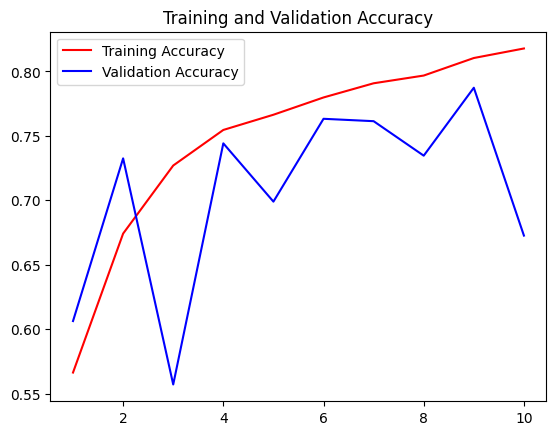

Training samples: 1000
Embedding layer test accuracy: 0.788
Pretrained embeddings test accuracy: 0.784
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.5283 - loss: 0.6902 - val_accuracy: 0.6202 - val_loss: 0.6428
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.7350 - loss: 0.5580 - val_accuracy: 0.7533 - val_loss: 0.5151
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.8266 - loss: 0.4157 - val_accuracy: 0.6930 - val_loss: 0.6625
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.8630 - loss: 0.3403 - val_accuracy: 0.8123 - val_loss: 0.4196
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9024 - loss: 0.2646 - val_accuracy: 0.7710 - val_loss: 0.5190
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9237 - loss: 0.2231 - val_accuracy: 0.8173 - val_loss: 0.4928
Epoch 7/10
157/157 ━━━━━━━━━━

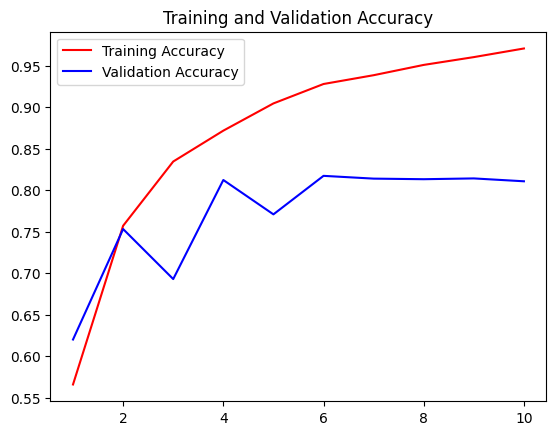

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.5507 - loss: 0.6924 - val_accuracy: 0.6692 - val_loss: 0.6096
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.6827 - loss: 0.6015 - val_accuracy: 0.6207 - val_loss: 0.6826
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.7208 - loss: 0.5494 - val_accuracy: 0.6579 - val_loss: 0.6222
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 0.7483 - loss: 0.5251 - val_accuracy: 0.7735 - val_loss: 0.4798
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.7666 - loss: 0.4917 - val_accuracy: 0.7390 - val_loss: 0.5246
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.7792 - loss: 0.4708 - val_accuracy: 0.7411 - val_loss: 0.5281
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.7854 - loss: 0.4607 - val_accuracy: 0.7057 - val_loss: 0.6148
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.8064 - loss: 0.4281 - val

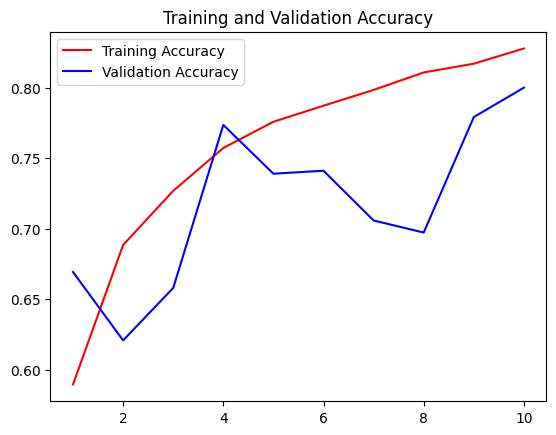

Training samples: 5000
Embedding layer test accuracy: 0.802
Pretrained embeddings test accuracy: 0.797
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.5194 - loss: 0.6899 - val_accuracy: 0.7128 - val_loss: 0.5853
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.7126 - loss: 0.5677 - val_accuracy: 0.7659 - val_loss: 0.5028
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8107 - loss: 0.4467 - val_accuracy: 0.7698 - val_loss: 0.4841
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.8683 - loss: 0.3491 - val_accuracy: 0.8035 - val_loss: 0.4552
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.8935 - loss: 0.2873 - val_accuracy: 0.8127 - val_loss: 0.4504
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9193 - loss: 0.2292 - val_accuracy: 0.8144 - val_loss: 0.4415
Epoch 7/10
157/157 ━━━━━━━━━

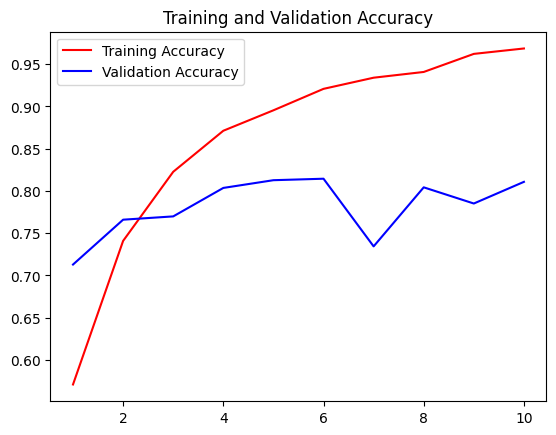

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.5601 - loss: 0.6874 - val_accuracy: 0.5974 - val_loss: 0.6613
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.6568 - loss: 0.6200 - val_accuracy: 0.6039 - val_loss: 0.6583
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.6859 - loss: 0.5812 - val_accuracy: 0.7272 - val_loss: 0.5508
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.7359 - loss: 0.5420 - val_accuracy: 0.7125 - val_loss: 0.5504
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.7693 - loss: 0.5036 - val_accuracy: 0.7693 - val_loss: 0.4850
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.7731 - loss: 0.4798 - val_accuracy: 0.7481 - val_loss: 0.5176
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.7926 - loss: 0.4587 - val_accuracy: 0.7907 - val_loss: 0.4532
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.8062 - loss: 0.4339 - v

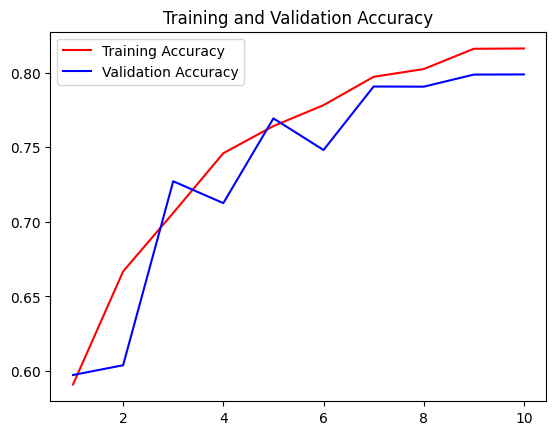

Training samples: 10000
Embedding layer test accuracy: 0.806
Pretrained embeddings test accuracy: 0.795
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.5099 - loss: 0.6911 - val_accuracy: 0.7137 - val_loss: 0.6066
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.7046 - loss: 0.5822 - val_accuracy: 0.7639 - val_loss: 0.5080
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8248 - loss: 0.4245 - val_accuracy: 0.8069 - val_loss: 0.4783
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.8503 - loss: 0.3623 - val_accuracy: 0.7855 - val_loss: 0.5045
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.8956 - loss: 0.2808 - val_accuracy: 0.8008 - val_loss: 0.4916
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9135 - loss: 0.2489 - val_accuracy: 0.8121 - val_loss: 0.4812
Epoch 7/10
157/157 ━━━━━━━

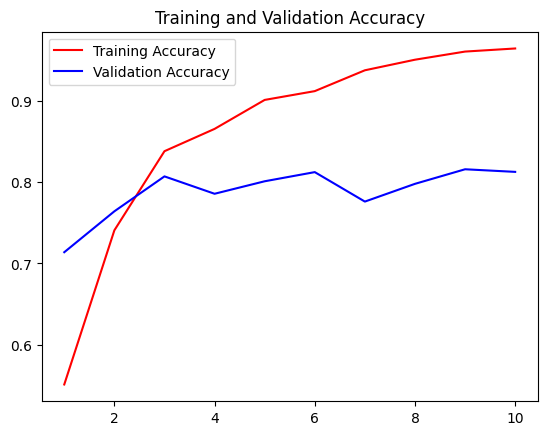

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.5387 - loss: 0.6933 - val_accuracy: 0.6828 - val_loss: 0.6100
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.6718 - loss: 0.6095 - val_accuracy: 0.7393 - val_loss: 0.5437
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.7270 - loss: 0.5503 - val_accuracy: 0.7561 - val_loss: 0.5141
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.7533 - loss: 0.5140 - val_accuracy: 0.6315 - val_loss: 0.7380
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 0.7652 - loss: 0.5026 - val_accuracy: 0.7753 - val_loss: 0.4745
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7819 - loss: 0.4706 - val_accuracy: 0.7850 - val_loss: 0.4633
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.7845 - loss: 0.4492 - val_accuracy: 0.7875 - val_loss: 0.4493
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.8069 - loss: 0.4293 - v

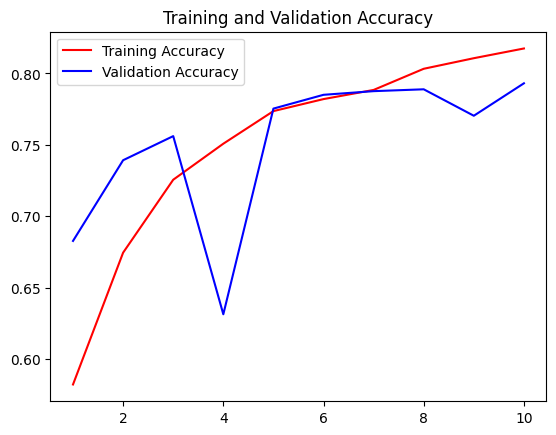

Training samples: 20000
Embedding layer test accuracy: 0.806
Pretrained embeddings test accuracy: 0.795
--------------------------------------------------


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

train_sample_sizes = [100, 500, 1000, 5000, 10000, 20000]

for train_size in train_sample_sizes:
    raw_train_dataset = keras.utils.text_dataset_from_directory(
        "aclImdb/train", batch_size=batchSize
    ).take(train_size)

    raw_train_dataset_vectorized = raw_train_dataset.map(
        lambda x, y: (text_vectorizer_layer(x), y),
        num_parallel_calls=4
    )
    int_raw_validation_dataset = raw_validation_dataset.map(
        lambda x, y: (text_vectorizer_layer(x), y),
        num_parallel_calls=4
    )
    raw_test_dataset_vectorized = raw_test_dataset.map(
        lambda x, y: (text_vectorizer_layer(x), y),
        num_parallel_calls=4
    )

    # Train and evaluate the sentiment_classifier with the embedding layer
    trainable_embedding_layer = layers.Embedding(MAX_VOCAB_SIZE, embedding_dimension)

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = trainable_embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    output_logits = layers.Dense(1, activation="sigmoid")(x)

    sentiment_classifier = keras.Model(inputs=inputs, outputs=output_logits)
    sentiment_classifier.compile(optimizer="rmsprop",
                            loss="binary_crossentropy",
                            metrics=["accuracy"])

    callbacks = [
        ModelCheckpoint("embeddings_sentiment_classifier.keras", save_best_only=True)
    ]
    history = sentiment_classifier.fit(raw_train_dataset_vectorized,
                                  validation_data=int_raw_validation_dataset,
                                  epochs=10,
                                  callbacks=callbacks)

    sentiment_classifier = keras.models.load_model("embeddings_sentiment_classifier.keras")
    trainable_embedding_layer_test_acc = sentiment_classifier.evaluate(raw_test_dataset_vectorized)[1]

    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)

    plt.figure()
    plt.plot(epochs, loss, "r", label="Training Accuracy")
    plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()

    # Train and evaluate the sentiment_classifier with the pretrained word embeddings
    trainable_embedding_layer = layers.Embedding(
        MAX_VOCAB_SIZE,
        embedding_dimension,
        embeddings_initializer=keras.initializers.Constant(glove_embedding_matrix),
        trainable=False,
        mask_zero=True,
    )

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = trainable_embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    output_logits = layers.Dense(1, activation="sigmoid")(x)

    sentiment_classifier = keras.Model(inputs=inputs, outputs=output_logits)
    sentiment_classifier.compile(optimizer="rmsprop",
                            loss="binary_crossentropy",
                            metrics=["accuracy"])

    callbacks = [
        ModelCheckpoint("pretrained_embeddings_sentiment_classifier.keras", save_best_only=True)
    ]
    history = sentiment_classifier.fit(raw_train_dataset_vectorized,
                                  validation_data=int_raw_validation_dataset,
                                  epochs=10,
                                  callbacks=callbacks)

    sentiment_classifier = keras.models.load_model("pretrained_embeddings_sentiment_classifier.keras")
    pretrained_embeddings_test_acc = sentiment_classifier.evaluate(raw_test_dataset_vectorized)[1]

    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)

    plt.figure()
    plt.plot(epochs, loss, "r", label="Training Accuracy")
    plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()

    # Compare the performance and store the results
    print(f"Training samples: {train_size}")
    print(f"Embedding layer test accuracy: {trainable_embedding_layer_test_acc:.3f}")
    print(f"Pretrained embeddings test accuracy: {pretrained_embeddings_test_acc:.3f}")
    print("-" * 50)
